In [9]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

import shap
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r"C:\Users\User\Downloads\diabetes+130-us+hospitals+for+years+1999-2008 (1)\diabetic_data.csv")
print("Shape:", df.shape)

# Target encoding
target = "readmitted"
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == "<30" else 0)
print(y.value_counts(normalize=True))

Shape: (101766, 50)
readmitted
0    0.888401
1    0.111599
Name: proportion, dtype: float64


In [11]:
#Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
print(f"Categorical: {len(categorical_cols)} | Numeric: {len(numeric_cols)}")

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Temporal split to avoid leakage
if "admission_type_id" in df.columns:
    X["admission_order"] = np.arange(len(X))
    sorted_idx = X["admission_order"].sort_values().index
    X_sorted, y_sorted = X.loc[sorted_idx], y.loc[sorted_idx]
    split_idx = int(0.8 * len(X_sorted))
    X_train, X_test = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
    y_train, y_test = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Categorical: 36 | Numeric: 13
Train size: (81412, 50) Test size: (20354, 50)


In [12]:
print("Running feature selection once with RandomForest...")
fs_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("selector", SelectFromModel(fs_model))
])
selector_pipeline.fit(X_train, y_train)

# Transform datasets
X_train_fs = selector_pipeline.transform(X_train)
X_test_fs = selector_pipeline.transform(X_test)

# Get selected feature names
mask = selector_pipeline.named_steps["selector"].get_support()
feature_names_all = (
    numeric_cols +
    list(selector_pipeline.named_steps["preprocessor"]
         .transformers_[1][1]["encoder"].get_feature_names_out(categorical_cols))
)
selected_features = [f for f, m in zip(feature_names_all, mask) if m]
print(f"Selected {len(selected_features)} features: {selected_features[:10]}...")

Running feature selection once with RandomForest...
Selected 347 features: ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient']...



Training LogisticRegression...
LogisticRegression: Acc=0.894, AUC=0.643, Brier=0.092

Training RandomForest...
RandomForest: Acc=0.894, AUC=0.627, Brier=0.093

Training XGBoost...
XGBoost: Acc=0.894, AUC=0.650, Brier=0.093

Training SVM...
SVM: Acc=0.894, AUC=0.596, Brier=0.093


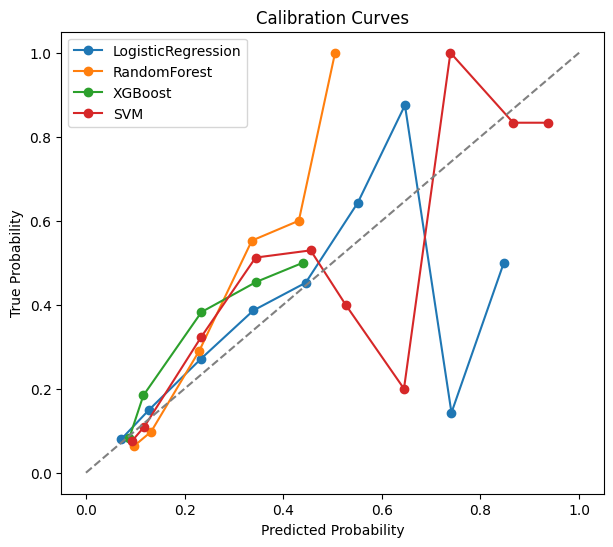


=== Model Comparison ===
LogisticRegression -> {'Accuracy': 0.8940748747175002, 'ROC-AUC': 0.6430673603200753, 'Brier': 0.09201538811586203, 'y_prob': array([0.06536457, 0.08779783, 0.0476668 , ..., 0.06142273, 0.09092257,
       0.06904257], shape=(20354,))}
RandomForest -> {'Accuracy': 0.8936327011889554, 'ROC-AUC': 0.6265600725113141, 'Brier': 0.09337423247344089, 'y_prob': array([0.13694941, 0.12164276, 0.11802705, ..., 0.11744956, 0.17010836,
       0.13704174], shape=(20354,))}
XGBoost -> {'Accuracy': 0.8935344404048344, 'ROC-AUC': 0.6503338680455766, 'Brier': 0.09343592925166805, 'y_prob': array([0.08506228, 0.082962  , 0.08421397, ..., 0.08913427, 0.09342743,
       0.08497706], shape=(20354,))}
SVM -> {'Accuracy': 0.8937800923651371, 'ROC-AUC': 0.5960574332761863, 'Brier': 0.09325302550016035, 'y_prob': array([0.10131697, 0.12058151, 0.09727059, ..., 0.12820189, 0.12028113,
       0.11454554], shape=(20354,))}


In [13]:
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric="logloss", use_label_encoder=False, n_jobs=-1),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42)  # slower
}

results = {}
plt.figure(figsize=(7, 6))

for name, model in base_models.items():
    print(f"\nTraining {name}...")
    calibrated = CalibratedClassifierCV(clone(model), method="sigmoid", cv=3, n_jobs=1)

    if name == "SVM":
        # Use 30% of training data for SVM to save time
        n_samples = X_train_fs.shape[0]
        sample_idx = np.random.choice(n_samples, size=int(0.3*n_samples), replace=False)
        calibrated.fit(X_train_fs[sample_idx], y_train.iloc[sample_idx])
    else:
        calibrated.fit(X_train_fs, y_train)

    y_pred = calibrated.predict(X_test_fs)
    y_prob = calibrated.predict_proba(X_test_fs)[:,1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)

    # Save probabilities for DCA
    results[name] = {
        "Accuracy": acc,
        "ROC-AUC": auc,
        "Brier": brier,
        "y_prob": y_prob
    }

    print(f"{name}: Acc={acc:.3f}, AUC={auc:.3f}, Brier={brier:.3f}")

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curves")
plt.legend()
plt.show()

print("\n=== Model Comparison ===")
for model, scores in results.items():
    print(f"{model} -> {scores}")

Computing SHAP values for XGBoost...


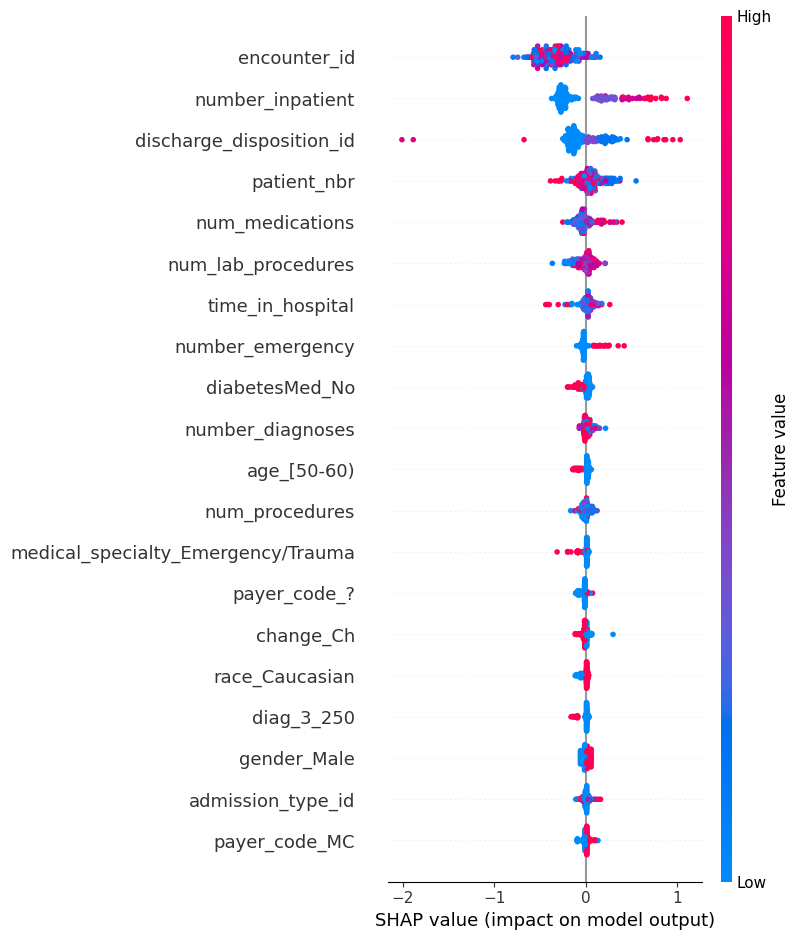

In [14]:
print("Computing SHAP values for XGBoost...")

# Convert sparse matrices to dense
X_train_dense = X_train_fs.toarray() if hasattr(X_train_fs, "toarray") else X_train_fs
X_test_dense = X_test_fs.toarray() if hasattr(X_test_fs, "toarray") else X_test_fs

xgb = XGBClassifier(n_estimators=100, eval_metric="logloss", use_label_encoder=False, n_jobs=-1)
xgb.fit(X_train_dense, y_train)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_test_dense[:200])

shap.summary_plot(shap_values, features=X_test_dense[:200], feature_names=selected_features, show=True)

In [16]:
# Compute mean absolute SHAP values
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": selected_features,
    "MeanAbsSHAP": shap_abs_mean
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="MeanAbsSHAP", ascending=False).reset_index(drop=True)

# Add impact direction
mean_shap = shap_values.values.mean(axis=0)
feature_importance_df["ImpactDirection"] = np.where(mean_shap > 0, "↑ Readmission Risk",
                                                   np.where(mean_shap < 0, "↓ Readmission Risk", "Neutral"))

# Display top 15 features
print("Top 15 Clinically Relevant Features Based on SHAP:")
display(feature_importance_df.head(15))


Top 15 Clinically Relevant Features Based on SHAP:


,Feature,MeanAbsSHAP,ImpactDirection
0,encounter_id,0.332084,↓ Readmission Risk
1,number_inpatient,0.289246,↑ Readmission Risk
2,discharge_disposition_id,0.198804,↑ Readmission Risk
3,patient_nbr,0.110353,↓ Readmission Risk
4,num_medications,0.068828,↑ Readmission Risk
5,num_lab_procedures,0.065887,↑ Readmission Risk
6,time_in_hospital,0.052474,↓ Readmission Risk
7,number_emergency,0.047591,↓ Readmission Risk
8,diabetesMed_No,0.034890,↓ Readmission Risk
9,number_diagnoses,0.031916,↑ Readmission Risk
